In [1]:
# Importing modules
import pandas as pd
import numpy as np
from scripts.preprocessing import preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
import joblib

In [2]:
# Data for training and validation
train_data = preprocess("data/train_set").spectra2df()

# Data for testing (Blind)
test_data = preprocess("data/test_set").spectra2df()

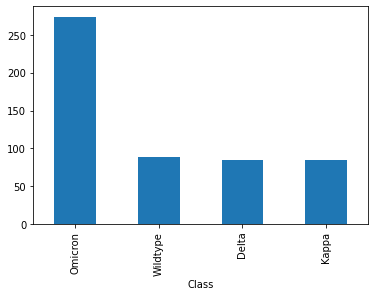

In [3]:
# Class distribution (Training and validation set)
train_data["Class"].value_counts().plot.bar()
plt.show()

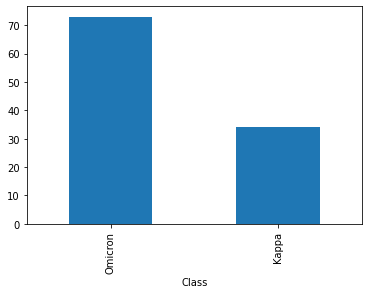

In [4]:
# Class distribution (Test/Blind set)
test_data["Class"].value_counts().plot.bar()
plt.show()

In [5]:
# Target labels
y = train_data["Class"]

# Feature matrix
X = train_data.drop(["Class", "Sample"], axis=1) 

# Training and validation split (80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Oversampling training set
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

# Scaling training and validation set
sds = joblib.load("models/scaler.pkl") # Loading scaler params
scaled_X_train = sds.transform(X_train_os)
scaled_X_val = sds.transform(X_val)

# Reshaping
scaled_X_train = scaled_X_train.reshape(scaled_X_train.shape[0], 1, scaled_X_train.shape[1])
scaled_X_val = scaled_X_val.reshape(scaled_X_val.shape[0], 1, scaled_X_val.shape[1])

# Label encoding
label_encoder = LabelEncoder()
y_train_os = label_encoder.fit_transform(y_train_os)
y_val = label_encoder.transform(y_val)

# Tensor
X_train_tensor = torch.tensor(scaled_X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_os, dtype=torch.long)
X_val_tensor = torch.tensor(scaled_X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Dataloader
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

In [6]:
# Attention
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn_weights = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        attn_scores = self.attn_weights(lstm_output).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(lstm_output * attn_weights.unsqueeze(-1), dim=1)
        return context

# BiLSTM Model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, 
                            dropout=dropout_prob, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.attention(out)
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Model (BiLSTM Model with attention mechanism)
model = BiLSTMClassifier(1400, 256, 3, len(label_encoder.classes_))
print(model)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

BiLSTMClassifier(
  (lstm): LSTM(1400, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Attention(
    (attn_weights): Linear(in_features=512, out_features=1, bias=True)
  )
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)


In [7]:
# Model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss = []
train_accuracy = []
n_epoch = 25
for epoch in range(n_epoch):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    num_batches = len(train_loader)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    train_acc = correct / total
    avg_loss = total_loss / num_batches
    train_loss.append(avg_loss)
    train_accuracy.append(train_acc)

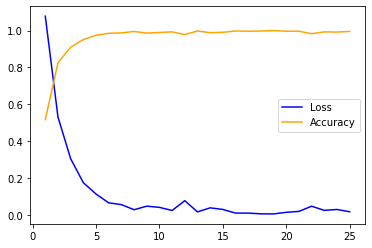

In [8]:
# Accuracy loss curve
plt.plot(np.arange(1, n_epoch+1, 1) , train_loss, c="blue", label="Loss")
plt.plot(np.arange(1, n_epoch+1, 1) , train_accuracy, c="orange", label="Accuracy")
plt.legend()
plt.show()

In [9]:
# Model validation
model.eval()
y_val, y_pred_val = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_val.extend(y_batch.cpu().numpy())
        y_pred_val.extend(predicted.cpu().numpy())

In [10]:
# Classification report (Validation set)
print(classification_report(label_encoder.inverse_transform(y_val), label_encoder.inverse_transform(y_pred_val)))

              precision    recall  f1-score   support

       Delta       0.88      0.88      0.88        17
       Kappa       0.72      0.76      0.74        17
     Omicron       0.92      0.85      0.89        55
    Wildtype       0.81      0.94      0.87        18

    accuracy                           0.86       107
   macro avg       0.83      0.86      0.85       107
weighted avg       0.86      0.86      0.86       107



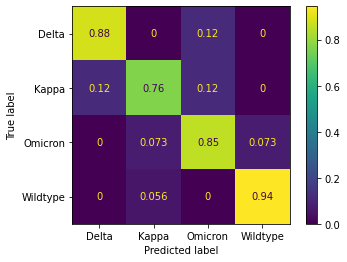

In [11]:
# Confusion matrix (Validation set)
cmat = confusion_matrix(label_encoder.inverse_transform(y_val), label_encoder.inverse_transform(y_pred_val), 
                        labels=label_encoder.classes_, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=label_encoder.classes_)
disp_cmat.plot()
plt.show()

In [12]:
# Saving the model 
torch.save(model, "models/BiLSTM_model.pth")

In [13]:
# Target labels (Test set)
y_test = test_data["Class"]
y_test = label_encoder.transform(y_test)

# Feature matrix (Test set)
X_test = test_data.drop(["Class", "Sample"], axis=1)

# Scaling Test set
scaled_X_test = sds.transform(X_test)

# Reshaping
scaled_X_test = scaled_X_test.reshape(scaled_X_test.shape[0], 1, scaled_X_test.shape[1])

# Tensor
X_test_tensor = torch.tensor(scaled_X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataloader
batch_size = 16
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [14]:
# Loading BiLSTM model
model = torch.load("models/BiLSTM_model.pth") 

# Model testing
model.eval()
y_test, y_pred_test = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_test.extend(y_batch.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

In [15]:
# Classification report (Test set)
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_test)))

              precision    recall  f1-score   support

       Delta       0.00      0.00      0.00         0
       Kappa       0.53      0.50      0.52        34
     Omicron       0.89      0.79      0.84        73
    Wildtype       0.00      0.00      0.00         0

    accuracy                           0.70       107
   macro avg       0.36      0.32      0.34       107
weighted avg       0.78      0.70      0.74       107



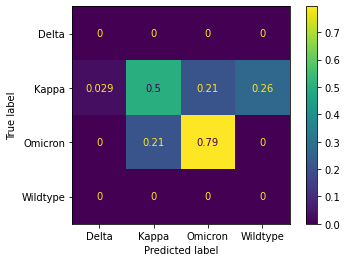

In [16]:
# Confusion matrix (Test set)
cmat = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_test), 
                        labels=label_encoder.classes_, normalize="true")
disp_cmat = ConfusionMatrixDisplay(confusion_matrix=cmat, display_labels=label_encoder.classes_)
disp_cmat.plot()
plt.show()